# **Першопочаткове налаштування**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

if tf.config.list_physical_devices('GPU'):
  print("TensorFlow IS using the GPU")
else:
  print("TensorFlow IS NOT using the GPU")

TensorFlow IS NOT using the GPU


Налаштування було успішним, у ході експериментів використовуватиметься GPU.

Перейдемо до реалізації практичного завдання лабораторної роботи, завантаживши класичний датасет для задачі класифікації зображень Fashion MNIST, що складається з зображень розміром 28*28 пікселів у сірому діапазоні кольорів.

Так як цей датасет вбудований в Keras, завантажимо його одразу:

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Завантажені зображення є, по суті, масивами пікселів, значення кожного з пікселів варіюється від 0 до 255, включно, а значення кожного з лейблів у масивах лейблів варіюються від 0 до 9 включно, ці значення є фактичними класами, до яких нейромережа приписуватиме зображення.

Так як ми хочемо отримати відносно точні результати у наслідку тренування нейромережі, одразу нормалізуємо формат даних таким чином, аби кожне значення використовуваних нейромережею масивів відповідало діапазону [0; 1].

Зробити це можна, поділивши значення масивів пікселів на 255, адже це є найбільшим значенням у масивах:

In [3]:
train_images = train_images / 255.0
test_images = test_images / 255.0

# **Побудова початкової моделі**

Побудуємо архітектуру простої секвентальної нейромережі (Sequential API):

In [4]:
model = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Дана модель матиме три слої:

1.  Вхідний слой Flatten, за рахунок пре-процесингу якого двомірні матриці пікселів перегортаються в одномірні масиви чисел, з якими зможе працювати нейромережа;
2.  Прихований слой Dense, який є основним обчислювальним слоєм з 128 нейронами, активаційна функція relu використовується через свою поширеність у простих задачах класифікації зображень;
3.  Вихідний слой Dense, має 10 нейронів для кожного з класів зображень ([0; 9]), активаційна функція softmax використовується для автоматичної конвертації вихідних даних у відсоткові значення для кожного з 10 класів.



# **Компіляція початкової моделі**

Проведемо компіляцію моделі та виведемо її архітектуру:

In [5]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        'accuracy',
        keras.losses.SparseCategoricalCrossentropy(name='xent')
        ]
)

У кожної мережі є три основні компіляційні параметри: функція оптимізації (optimizer), функція втрати (loss) і параметр виведення (metrics). Розглянемо вибір кожного з них:



*   Optimizer: було обрано Adam, адже ця функція є найбільш поширеною для задач класифікації;
*   Loss: було обрано Sparse Categorical Crossentropy, адже ця функція є найбільш поширеною для задач класифікації;
*   Metrics: було обрано accuracy, адже по ходу тестування ми бажаємо бачити саме точність моделі нейромережі.



Виведемо підсумки зкомпільованої моделі нейромережі:

In [6]:
model.summary()

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Як можемо побачити, у створеній моделі:


1.   На першому слої: 784 (28*28) вхідних параметри, і 0 вихідних, адже слой є виключно вхідним;
2.   На другому слої: 128 вхідних параметрів (за кількістю нейронів), і 100480 (784 * 128 + 128 зміщень за замовчуванням) вихідних параметрів;
3. На третьому слої: 10 вхідних параметрів (за кількістю нейронів), і 1290 (128 * 10 + 10 зміщень за замовчуванням) вихідних параметрів;



# **Тренування початкової моделі**

Виконаємо першопочаткове тренування моделі з 10 епохами, і виділенням 20% тренувальних даних (12000 з 60000) на валідацію, аби розміри даних для валідації (12000) та тестування (10000) були приблизно однаковими:

In [7]:
history = model.fit(train_images, train_labels, epochs=10, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7703 - loss: 0.6555 - xent: 0.6555 - val_accuracy: 0.8502 - val_loss: 0.4162 - val_xent: 0.4162
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8620 - loss: 0.3923 - xent: 0.3923 - val_accuracy: 0.8457 - val_loss: 0.4132 - val_xent: 0.4132
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8735 - loss: 0.3495 - xent: 0.3495 - val_accuracy: 0.8572 - val_loss: 0.4004 - val_xent: 0.4004
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8823 - loss: 0.3252 - xent: 0.3252 - val_accuracy: 0.8731 - val_loss: 0.3604 - val_xent: 0.3604
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8893 - loss: 0.3058 - xent: 0.3058 - val_accuracy: 0.8741 - val_loss: 0.3496 - val_xent: 0.3496
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8957 - loss: 0.2812 - xent: 0.2812 - val_accuracy: 0.8827 - val_loss: 0.3294 - val_xent: 0.3294
Epoch 7/10
1500/1500 ━━━━━━

Тепер, виконаємо аналіз точності моделі на тестових даних:

In [8]:
print("--- Перевіряємо точність моделі на тестових даних ---")
test_loss, test_accuracy, test_xent = model.evaluate(test_images, test_labels, verbose=2)
print("Тестова точність:", test_accuracy)
print("Тестова помилка:", test_loss)
print("Тестова фактична помилка:", test_xent)

--- Перевіряємо точність моделі на тестових даних ---
313/313 - 1s - 3ms/step - accuracy: 0.8683 - loss: 0.3815 - xent: 0.3811
Тестова точність: 0.8683000206947327
Тестова помилка: 0.3814918100833893
Тестова фактична помилка: 0.3811151087284088


Виведемо на графіку результати тестувань, що покажуть ефективність моделі:

In [9]:
def display_results(history, model=None, title=None):
  name = (
        title
        or (getattr(model, 'name', None))
        or (getattr(getattr(history, 'model', None), 'name', None))
        or 'Модель'
      )

  history_dictionary = history.history
  accuracy = history_dictionary['accuracy']
  val_accuracy = history_dictionary['val_accuracy']
  loss = history_dictionary['loss']
  val_loss = history_dictionary['val_loss']
  epochs_range = range(1, len(accuracy) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  fig.suptitle(f'Модель: {name}', fontsize=14, y=1.03)

  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, accuracy, 'o-', color='#1f77b4', label='Точність тренування')
  plt.plot(epochs_range, val_accuracy, '-', color='#ff7f0e', label='Точність валідації')
  plt.title('Точність тренування і валідації')
  plt.xlabel('Епохи')
  plt.ylabel('Точність')
  plt.ylim(0.5, 1.0)
  plt.legend()
  plt.grid(alpha=0.2)

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, 'o-', color='#1f77b4', label='Помилка тренування')
  plt.plot(epochs_range, val_loss, '-', color='#ff7f0e', label='Помилка валідації')
  plt.title('Помилка тренування і валідації')
  plt.xlabel('Епохи')
  plt.ylabel('Помилка')
  plt.ylim(0.0, 0.5)
  plt.legend()
  plt.grid(alpha=0.2)

  fig.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


In [10]:
def display_all_results(histories, value, miny=0.25, maxy=0.45, title='Порівняння', ylabel=None, epochs=30):
  plt.figure(figsize=(10, 6))
  for name, history in histories.items():
    plt.plot(history.history[value], label=name)

  plt.xlabel("Епохи")
  plt.ylabel(ylabel)
  plt.title(title)
  plt.legend()
  plt.grid(alpha=0.2)
  plt.xlim([0, epochs])
  plt.ylim([miny, maxy])
  plt.show()

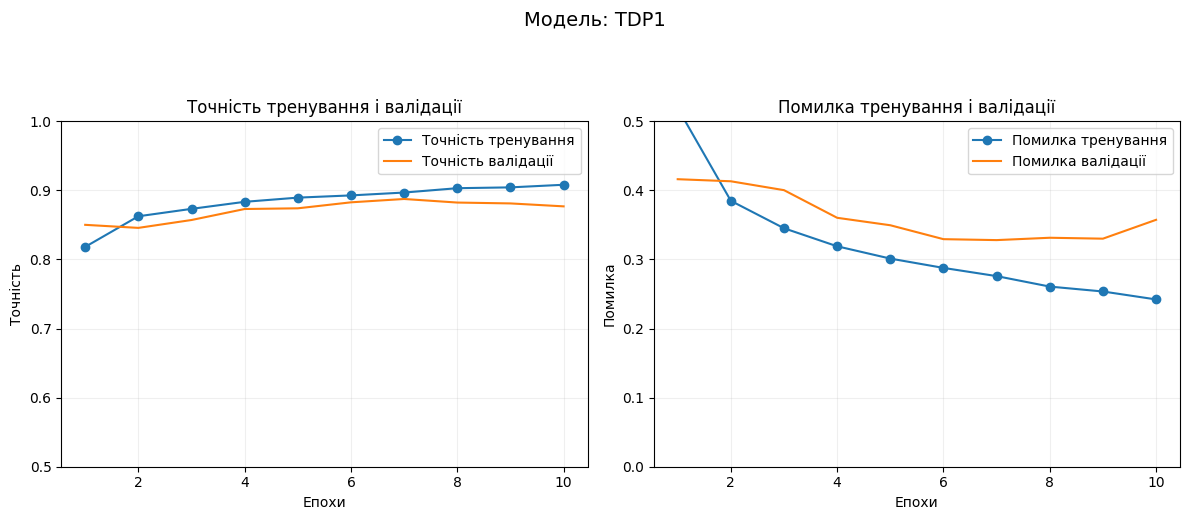

In [11]:
display_results(history)

Як можемо побачити, приблизно після 4 епох зменшується точність валідації даних, непропорційно тренувальним даним.

Спробуємо різні оптимізації, аби побачити їхній ефект на точності моделі, але спочатку збережемо першопочаткову модель:

In [12]:
model.save('tdp1_model_v1.keras')
print('\nЗбережено модель tdp1_model_v1')


Збережено модель tdp1_model_v1


# **Оптимізація місткості моделі**

Так як тестування виконуватимуться на відносно невеликому та збалансованому датасеті, звичайне використання системи збереження контрольних точок під час тренування не є обов'язковим.

Натомість, застосуємо цю систему для збереження найкращої моделі під час кожного індивідуального тренування, таким чином, навіть якщо тренування буде перерване, існуватиме модель, з якої можна буде відновити тренування, і наприкінці можна буде порівняти результати такої моделі з фактичними фінальними:

In [13]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='best_model_checkpoint.keras',
    monitor='val_xent',
    save_best_only=True,
    mode='min',
    verbose=1
)

Спочатку, аби запобігти перенавчання у будь-якому майбутньому сценаріЇ, застосуємо метод ранньої зупинки зі значенням толерантності 10:

In [14]:
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_xent',
    patience=10,
    min_delta=1e-3,
    restore_best_weights=True,
    mode='min'
)

Протестуємо раніше створену модель з новими гіперпараметрами, але спочатку визначимо загальні методи:

In [15]:
lr_reduction_callback = None;

In [16]:
def get_optimizer(lr=1e-3):
  return keras.optimizers.Adam(learning_rate=lr)

def get_lr_reduction_callback():
  return lr_reduction_callback

def compile_and_fit(model, name=None, optimizer=None, lr_callback=None, max_epochs=10000, batch_size=None):
  if optimizer is None:
    optimizer = get_optimizer()

  if lr_callback is None:
    lr_callback = get_lr_reduction_callback()
    if get_lr_reduction_callback() is None:
      callbacks = [early_stopping_callback, checkpoint_callback]
    else:
      lr_callback = get_lr_reduction_callback()
      callbacks = [early_stopping_callback, lr_callback, checkpoint_callback]
  else:
    callbacks = [early_stopping_callback, lr_callback, checkpoint_callback]

  model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        'accuracy',
        keras.losses.SparseCategoricalCrossentropy(name='xent')
            ]
    )

  model.summary()

  history = model.fit(
      train_images,
      train_labels,
      epochs=max_epochs,
      batch_size=batch_size,
      validation_split=0.2,
      callbacks=callbacks,
      verbose=1
      )
  return history

Протестуємо найпопулярніші адаптивні методи навчання, щоб визначити найкращий. Наразі використовується метод Adam, спробуємо порівняти його ефективність з методами Adagrad, RMSProp, Adadelta:

In [17]:
initial_model = keras.models.load_model('tdp1_model_v1.keras')

optimizer_histories = {}
optimizer_histories['adam'] = compile_and_fit(initial_model, optimizer=keras.optimizers.Adam(), max_epochs=15)
optimizer_histories['adagrad'] = compile_and_fit(initial_model, optimizer=keras.optimizers.Adagrad(), max_epochs=15)
optimizer_histories['rmsprop'] = compile_and_fit(initial_model, optimizer=keras.optimizers.RMSprop(), max_epochs=15)
optimizer_histories['adadelta'] = compile_and_fit(initial_model, optimizer=keras.optimizers.Adadelta(), max_epochs=15)

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9134 - loss: 0.2289 - xent: 0.2289
Epoch 1: val_xent improved from inf to 0.32863, saving model to best_model_checkpoint.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9134 - loss: 0.2289 - xent: 0.2289 - val_accuracy: 0.8880 - val_loss: 0.3286 - val_xent: 0.3286
Epoch 2/15
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9176 - loss: 0.2207 - xent: 0.2207
Epoch 2: val_xent did not improve from 0.32863
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9176 - loss: 0.2208 - xent: 0.2208 - val_accuracy: 0.8823 - val_loss: 0.3353 - val_xent: 0.3353
Epoch 3/15
1489/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9205 - loss: 0.2117 - xent: 0.2117
Epoch 3: val_xent improved from 0.32863 to 0.32726, saving model to best_model_checkpoint.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9205 - loss: 0.2118 - xent: 0.2118 - val_accuracy: 0.8840 - val_loss: 0.3273 - val_xent: 0.32

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1488/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9349 - loss: 0.1708 - xent: 0.1708
Epoch 1: val_xent improved from 0.32601 to 0.30543, saving model to best_model_checkpoint.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9349 - loss: 0.1708 - xent: 0.1708 - val_accuracy: 0.8962 - val_loss: 0.3054 - val_xent: 0.3054
Epoch 2/15
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9418 - loss: 0.1623 - xent: 0.1623
Epoch 2: val_xent improved from 0.30543 to 0.30319, saving model to best_model_checkpoint.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9418 - loss: 0.1623 - xent: 0.1623 - val_accuracy: 0.8968 - val_loss: 0.3032 - val_xent: 0.3032
Epoch 3/15
1489/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9424 - loss: 0.1590 - xent: 0.1590
Epoch 3: val_xent improved from 0.30319 to 0.30299, saving model to best_model_checkpoint.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9424 - loss: 0.1589 - xent: 0.1589 - val

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9273 - loss: 0.1919 - xent: 0.1919
Epoch 1: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9273 - loss: 0.1919 - xent: 0.1919 - val_accuracy: 0.8954 - val_loss: 0.3433 - val_xent: 0.3433
Epoch 2/15
1491/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9298 - loss: 0.1893 - xent: 0.1893
Epoch 2: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9298 - loss: 0.1893 - xent: 0.1893 - val_accuracy: 0.8911 - val_loss: 0.3553 - val_xent: 0.3553
Epoch 3/15
1486/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9314 - loss: 0.1832 - xent: 0.1832
Epoch 3: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9314 - loss: 0.1832 - xent: 0.1832 - val_accuracy: 0.8968 - val_loss: 0.3558 - val_xent: 0.3558
Epoch 4/15
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9348 - loss: 0.1822 - x

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9351 - loss: 0.1750 - xent: 0.1750
Epoch 1: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9351 - loss: 0.1750 - xent: 0.1750 - val_accuracy: 0.8962 - val_loss: 0.3376 - val_xent: 0.3376
Epoch 2/15
1487/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9368 - loss: 0.1690 - xent: 0.1690
Epoch 2: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9369 - loss: 0.1690 - xent: 0.1690 - val_accuracy: 0.8968 - val_loss: 0.3344 - val_xent: 0.3344
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9380 - loss: 0.1656 - xent: 0.1656
Epoch 3: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9380 - loss: 0.1656 - xent: 0.1656 - val_accuracy: 0.8972 - val_loss: 0.3324 - val_xent: 0.3324
Epoch 4/15
1484/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9388 - loss: 0.1665 - x

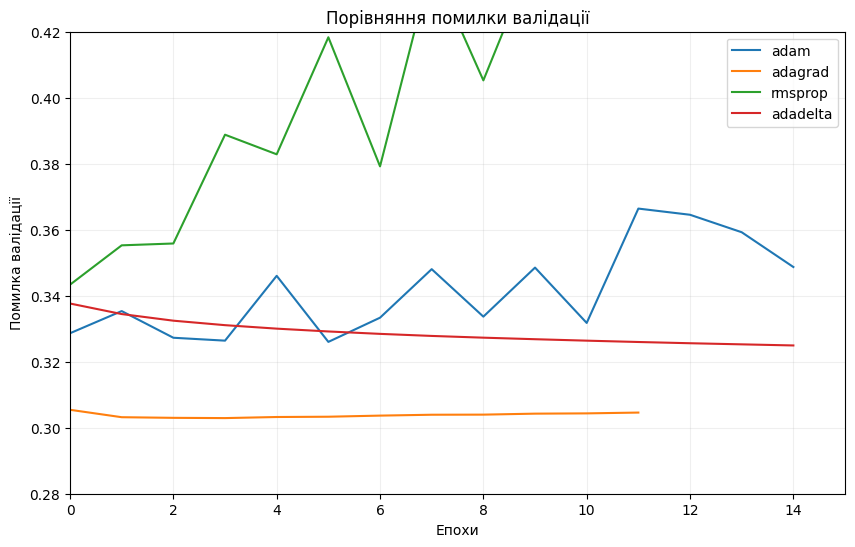

In [18]:
display_all_results(optimizer_histories, 'val_loss', miny=0.28, maxy=0.42, epochs=15, title='Порівняння помилки валідації', ylabel='Помилка валідації')

Як бачимо, метод Adam поступається приблизно на 1% помилки методу Adagrad, однак це викликано тим, що метод Adagrad, на відміну від методу Adam, використовує зниження швидкості навчання за замовчуванням. Вважатимемо таку малу різницю задовільною, і продовжимо з використанням методу Adam:

In [19]:
history = optimizer_histories['adam']

Протестуємо три різні конфігурації швидкості навчання, аби визначити, яка є найбільш оптимальною в нашому випадку.

Серед них:


*   Конфігурація 1 - середні зменшення, середня чутливість до покращень;
*   Конфігурація 2 - невеликі зменшення, низька чутливість до покращень;
*   Конфігурація 3 - сильні зменшення, висока чутливість до покращень.



In [20]:
lr_reduction_callback1 = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    cooldown=2,
    min_delta=1.5e-4,
    min_lr=5e-6,
    verbose=1,
    mode='min'
)

lr_reduction_callback2 = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    cooldown=2,
    min_delta=1e-3,
    min_lr=1e-6,
    verbose=1,
    mode='min'
)

lr_reduction_callback3 = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=6,
    cooldown=2,
    min_delta=5e-4,
    min_lr=1e-6,
    verbose=1,
    mode='min'
)

Застосуємо новостворені оптимізації на раніше збереженій моделі та виведемо результати порівняння всіх моделей:

In [21]:
initial_model = keras.models.load_model('tdp1_model_v1.keras')

lr_histories = {}
lr_histories['initial'] = history
lr_histories['lr1'] = compile_and_fit(initial_model, lr_callback=lr_reduction_callback1)
lr_histories['lr2'] = compile_and_fit(initial_model, lr_callback=lr_reduction_callback2)
lr_histories['lr3'] = compile_and_fit(initial_model, lr_callback=lr_reduction_callback3)

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1482/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9148 - loss: 0.2298 - xent: 0.2298
Epoch 1: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9148 - loss: 0.2298 - xent: 0.2298 - val_accuracy: 0.8841 - val_loss: 0.3327 - val_xent: 0.3327 - learning_rate: 0.0010
Epoch 2/10000
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9136 - loss: 0.2254 - xent: 0.2254
Epoch 2: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9136 - loss: 0.2254 - xent: 0.2254 - val_accuracy: 0.8868 - val_loss: 0.3231 - val_xent: 0.3231 - learning_rate: 0.0010
Epoch 3/10000
1484/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9176 - loss: 0.2173 - xent: 0.2173
Epoch 3: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9176 - loss: 0.2173 - xent: 0.2173 - val_accuracy: 0.8882 - val_loss: 0.3304 - val_xent: 0.3304 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1488/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9323 - loss: 0.1850 - xent: 0.1850
Epoch 1: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9323 - loss: 0.1850 - xent: 0.1850 - val_accuracy: 0.8890 - val_loss: 0.3293 - val_xent: 0.3293 - learning_rate: 0.0010
Epoch 2/10000
1484/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9332 - loss: 0.1751 - xent: 0.1751
Epoch 2: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9332 - loss: 0.1751 - xent: 0.1751 - val_accuracy: 0.8880 - val_loss: 0.3490 - val_xent: 0.3490 - learning_rate: 0.0010
Epoch 3/10000
1483/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9348 - loss: 0.1718 - xent: 0.1718
Epoch 3: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9348 - loss: 0.1718 - xent: 0.1718 - val_accuracy: 0.8917 - val_loss: 0.3357 - val_xent: 0.3357 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1489/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9327 - loss: 0.1801 - xent: 0.1801
Epoch 1: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9327 - loss: 0.1801 - xent: 0.1801 - val_accuracy: 0.8870 - val_loss: 0.3521 - val_xent: 0.3521 - learning_rate: 0.0010
Epoch 2/10000
1486/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9340 - loss: 0.1761 - xent: 0.1761
Epoch 2: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9340 - loss: 0.1762 - xent: 0.1762 - val_accuracy: 0.8907 - val_loss: 0.3513 - val_xent: 0.3513 - learning_rate: 0.0010
Epoch 3/10000
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9357 - loss: 0.1711 - xent: 0.1711
Epoch 3: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9357 - loss: 0.1712 - xent: 0.1712 - val_accuracy: 0.8852 - val_loss: 0.3599 - val_xent: 0.3599 - learning_rate: 0.0010
Epoch 4/10

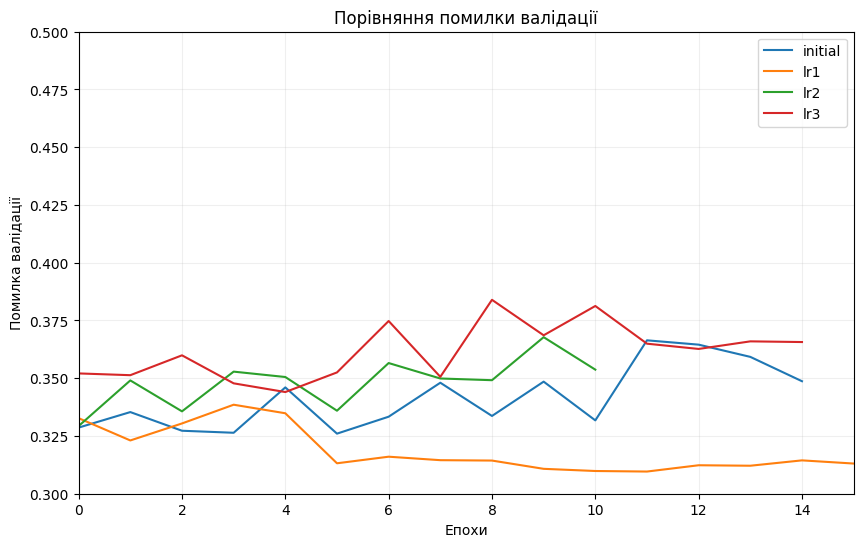

In [22]:
display_all_results(lr_histories, 'val_loss', miny=0.3, maxy=0.5, epochs=15, title='Порівняння помилки валідації', ylabel='Помилка валідації')

Як бачимо, результати другої конфігурації швидкості навчання є найкращими, що є логічним, адже вибірка даних є відносно рівномірно розподіленою на класи, та середньою за обсягом, і саме перший метод є найбільш стабільним - використовувати в подальшому ми будемо саме його.


Виведемо тепер результати тестування раніше збережної вибірки з щойно застосованими гіперпараметрами:

In [23]:
history = lr_histories['lr1']
lr_reduction_callback = lr_reduction_callback1

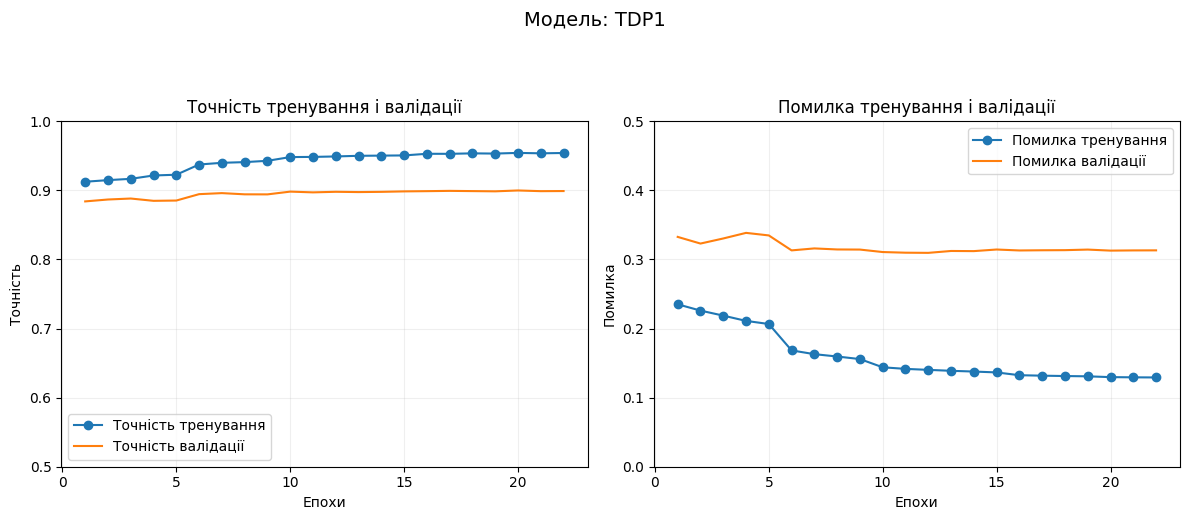

In [24]:
display_results(history)

Як можемо побачити, хоча запровадження зменшення швидкості навчання збільшило кількість епох з 10 до приблизно 25, результативна помилка на валідаційних даних краща.

Спробуємо тепер різні за розміром архітектури (кількість шарів та нейронів) з новоствореними пасивними оптимізаціями, аби визначити найбільш оптимальний розмір моделі. Визначимо початкові архітектури:

In [25]:
model_tiny = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_tiny'
)

model_small = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_small'
)

model_medium = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_medium'
)

model_large = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_large'
)

Проведемо компіляцію та тренування цих моделей:

In [26]:
size_histories = {}
size_histories['initial'] = history
size_histories['tiny'] = compile_and_fit(model_tiny)
size_histories['small'] = compile_and_fit(model_small)
size_histories['medium'] = compile_and_fit(model_medium)
size_histories['large'] = compile_and_fit(model_large)

Model: "TDP1_tiny"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,450 (99.41 KB)

 Trainable params: 25,450 (99.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7413 - loss: 0.7732 - xent: 0.7732
Epoch 1: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7416 - loss: 0.7724 - xent: 0.7724 - val_accuracy: 0.8388 - val_loss: 0.4580 - val_xent: 0.4580 - learning_rate: 0.0010
Epoch 2/10000
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8423 - loss: 0.4494 - xent: 0.4494
Epoch 2: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8423 - loss: 0.4493 - xent: 0.4493 - val_accuracy: 0.8542 - val_loss: 0.4168 - val_xent: 0.4168 - learning_rate: 0.0010
Epoch 3/10000
1478/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8589 - loss: 0.3980 - xent: 0.3980
Epoch 3: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8589 - loss: 0.3979 - xent: 0.3979 - val_accuracy: 0.8507 - val_loss: 0.4089 - val_xent: 0.4089 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1494/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7679 - loss: 0.6825 - xent: 0.6825
Epoch 1: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7681 - loss: 0.6819 - xent: 0.6819 - val_accuracy: 0.8379 - val_loss: 0.4617 - val_xent: 0.4617 - learning_rate: 0.0010
Epoch 2/10000
1479/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8499 - loss: 0.4173 - xent: 0.4173
Epoch 2: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8500 - loss: 0.4172 - xent: 0.4172 - val_accuracy: 0.8526 - val_loss: 0.4103 - val_xent: 0.4103 - learning_rate: 0.0010
Epoch 3/10000
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8668 - loss: 0.3695 - xent: 0.3695
Epoch 3: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8669 - loss: 0.3695 - xent: 0.3695 - val_accuracy: 0.8662 - val_loss: 0.3759 - val_xent: 0.3759 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_medium"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7673 - loss: 0.6702 - xent: 0.6702
Epoch 1: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7674 - loss: 0.6698 - xent: 0.6698 - val_accuracy: 0.8487 - val_loss: 0.4197 - val_xent: 0.4197 - learning_rate: 0.0010
Epoch 2/10000
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8604 - loss: 0.3827 - xent: 0.3827
Epoch 2: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8604 - loss: 0.3827 - xent: 0.3827 - val_accuracy: 0.8545 - val_loss: 0.3923 - val_xent: 0.3923 - learning_rate: 0.0010
Epoch 3/10000
1488/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8732 - loss: 0.3451 - xent: 0.3451
Epoch 3: val_xent did not improve from 0.30292
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8733 - loss: 0.3450 - xent: 0.3450 - val_accuracy: 0.8742 - val_loss: 0.3493 - val_xent: 0.3493 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,762 (948.29 KB)

 Trainable params: 242,762 (948.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7699 - loss: 0.6530 - xent: 0.6530
Epoch 1: val_xent did not improve from 0.29912
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7700 - loss: 0.6527 - xent: 0.6527 - val_accuracy: 0.8457 - val_loss: 0.4084 - val_xent: 0.4084 - learning_rate: 0.0010
Epoch 2/10000
1491/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8635 - loss: 0.3772 - xent: 0.3772
Epoch 2: val_xent did not improve from 0.29912
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8635 - loss: 0.3771 - xent: 0.3771 - val_accuracy: 0.8711 - val_loss: 0.3608 - val_xent: 0.3608 - learning_rate: 0.0010
Epoch 3/10000
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8770 - loss: 0.3330 - xent: 0.3330
Epoch 3: val_xent did not improve from 0.29912
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8770 - loss: 0.3330 - xent: 0.3330 - val_accuracy: 0.8750 - val_loss: 0.3511 - val_xent: 0.3511 - learning_rate: 0.0010
Epoch 4/1

Виведемо результати на 4 графіки для кожної з моделей:

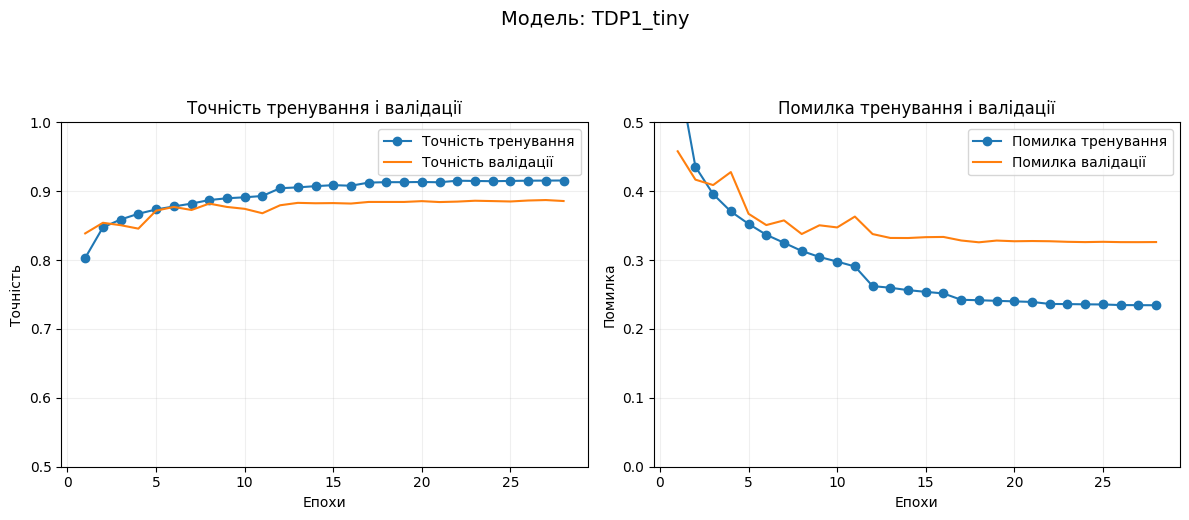

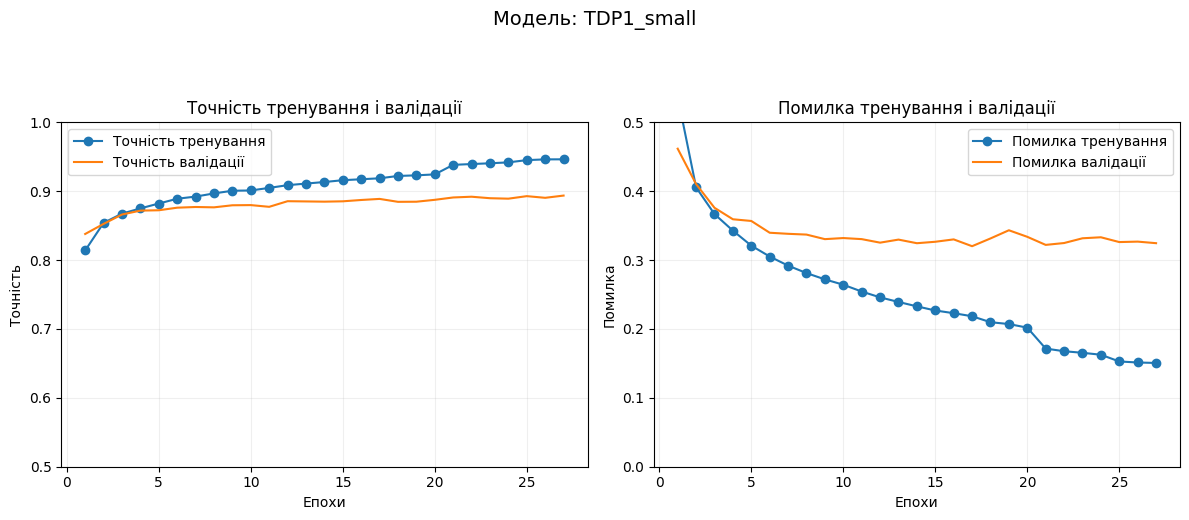

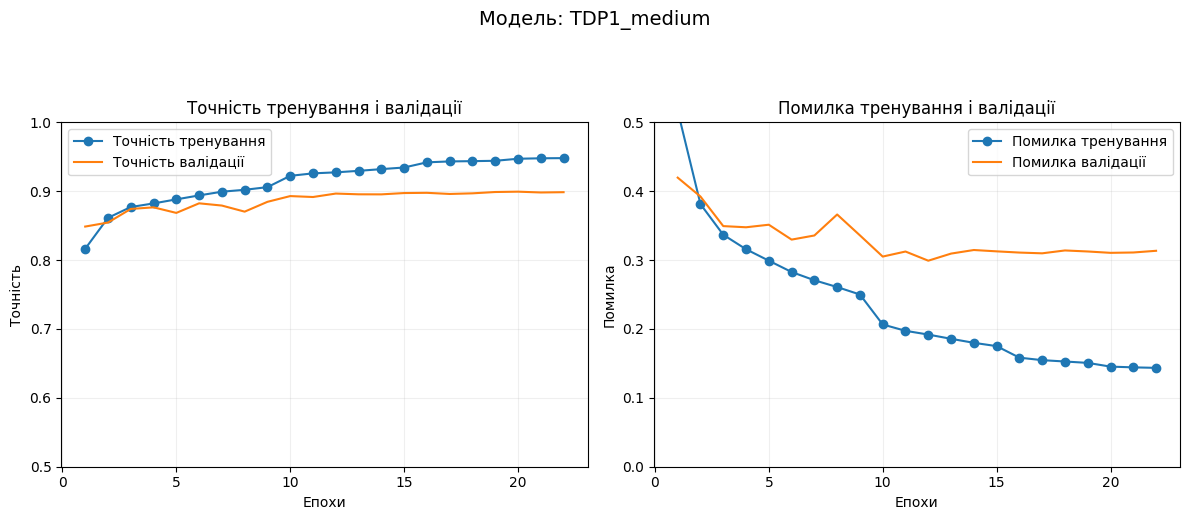

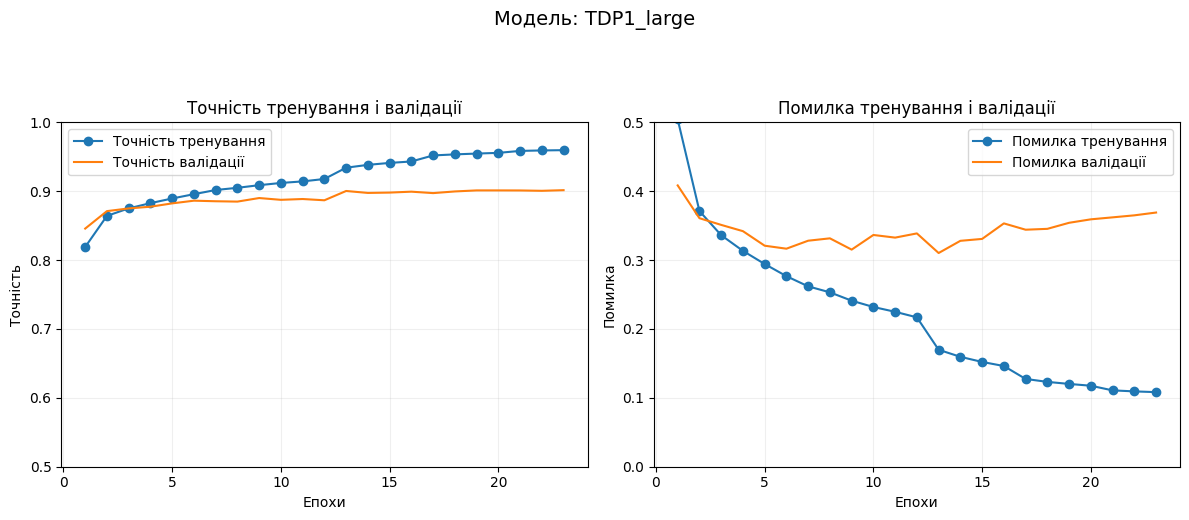

In [27]:
display_results(size_histories['tiny'])
display_results(size_histories['small'])
display_results(size_histories['medium'])
display_results(size_histories['large'])

Додатково, порівняємо на графіку результати помилки валідації всіх моделей, аби визначити найбільш підходящу для подальшої оптимізації архітектуру:

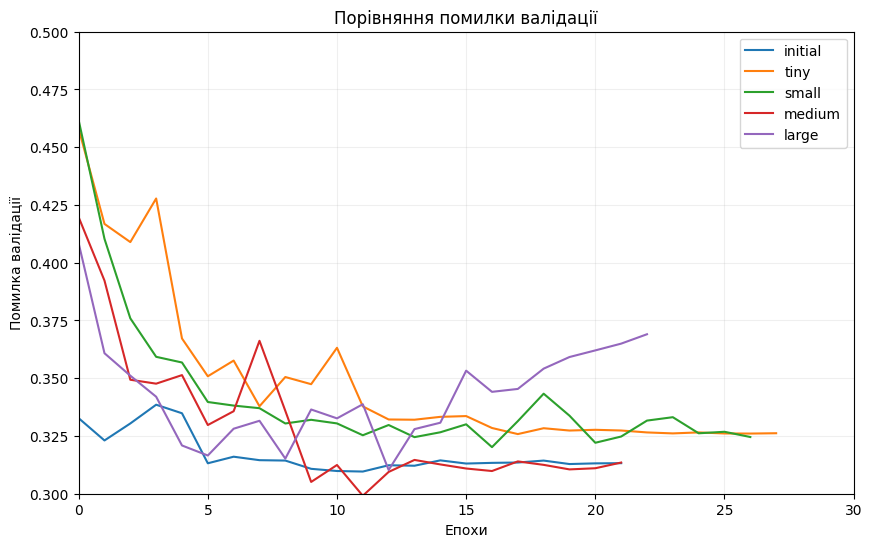

In [28]:
display_all_results(size_histories, 'val_loss', miny=0.3, maxy=0.5, title='Порівняння помилки валідації', ylabel='Помилка валідації')

Як можемо побачити, першопочаткова модель є занадто нестабільною через один прихований слой. Розглянемо інші моделі:


*   Крихітна модель - відбувається недонавчання, висока помилка на всіх епохах;
*   Мала модель - хороша помилка, однак ближче до 10 епох починаться перенавчання;
*   Середня модель - найнижча помилка протягом декількох епох, найбільш незначне перенавчання;
*   Велика модель - очевидне перенавчання;

Роблячи висновок із зображених на графіку результатів, найбільш підходящою моделлю для подальшого використання та оптимізації є середня модель. Мала модель є другим найкращим претендентом, і може буде використаною у ситуаціях де більш швидка модель є приорітетом точній моделі, але середня модель, в даному випадку, буде найбільш збалансованою, тож використаємо її.





Збережемо середню модель для подальших експериментів:

In [29]:
model_medium.save('tdp1_model_v2.keras')
print('\nЗбережено модель tdp1_model_v2')


Збережено модель tdp1_model_v2


# **Ліквідація перенавчання моделі**

Спробуємо застосувати подальші оптимізації, такі як L1/L2 регуляризації та Dropout, аби забезпечити ліквідацію перенавчання і подальше збільшення точності результатів.

Створимо дві моделі, що базуються на щойно збереженій середній моделі, кожна з яких застосуватиме різні види регуляризації: L1, L2 та L1 + L2:

In [30]:
model_medium_l1 = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1(1e-5)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1(1e-5)),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_medium_l1'
)

model_medium_l2 = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_medium_l2'
)

model_medium_l1l2 = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_medium_l1l2'
)

Виконаємо компіляцію та тестування нових моделей для порівняння результатів з оригіналом:

In [31]:
initial_model = keras.models.load_model('tdp1_model_v2.keras')

optimization_histories = {}
optimization_histories['initial'] = size_histories['medium']
optimization_histories['l1'] = compile_and_fit(model_medium_l1)
optimization_histories['l2'] = compile_and_fit(model_medium_l2)
optimization_histories['l1l2'] = compile_and_fit(model_medium_l1l2)

Model: "TDP1_medium_l1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1488/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7626 - loss: 0.7275 - xent: 0.6832
Epoch 1: val_xent did not improve from 0.29912
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7630 - loss: 0.7261 - xent: 0.6818 - val_accuracy: 0.8547 - val_loss: 0.4451 - val_xent: 0.4020 - learning_rate: 0.0010
Epoch 2/10000
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8629 - loss: 0.4266 - xent: 0.3834
Epoch 2: val_xent did not improve from 0.29912
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8629 - loss: 0.4266 - xent: 0.3834 - val_accuracy: 0.8649 - val_loss: 0.4125 - val_xent: 0.3687 - learning_rate: 0.0010
Epoch 3/10000
1496/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8707 - loss: 0.3945 - xent: 0.3501
Epoch 3: val_xent did not improve from 0.29912
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8708 - loss: 0.3945 - xent: 0.3501 - val_accuracy: 0.8658 - val_loss: 0.4111 - val_xent: 0.3655 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_medium_l2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1493/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7744 - loss: 0.6779 - xent: 0.6480
Epoch 1: val_xent did not improve from 0.29711
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7747 - loss: 0.6771 - xent: 0.6472 - val_accuracy: 0.8428 - val_loss: 0.4714 - val_xent: 0.4378 - learning_rate: 0.0010
Epoch 2/10000
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8596 - loss: 0.4176 - xent: 0.3830
Epoch 2: val_xent did not improve from 0.29711
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8596 - loss: 0.4176 - xent: 0.3830 - val_accuracy: 0.8635 - val_loss: 0.4156 - val_xent: 0.3780 - learning_rate: 0.0010
Epoch 3/10000
1487/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8720 - loss: 0.3879 - xent: 0.3494
Epoch 3: val_xent did not improve from 0.29711
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8720 - loss: 0.3879 - xent: 0.3493 - val_accuracy: 0.8634 - val_loss: 0.4135 - val_xent: 0.3726 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_medium_l1l2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7630 - loss: 0.7452 - xent: 0.6734
Epoch 1: val_xent did not improve from 0.29364
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7632 - loss: 0.7446 - xent: 0.6728 - val_accuracy: 0.8563 - val_loss: 0.4718 - val_xent: 0.4023 - learning_rate: 0.0010
Epoch 2/10000
1486/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8575 - loss: 0.4641 - xent: 0.3941
Epoch 2: val_xent did not improve from 0.29364
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8575 - loss: 0.4640 - xent: 0.3940 - val_accuracy: 0.8641 - val_loss: 0.4477 - val_xent: 0.3768 - learning_rate: 0.0010
Epoch 3/10000
1494/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8715 - loss: 0.4261 - xent: 0.3547
Epoch 3: val_xent did not improve from 0.29364
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8715 - loss: 0.4261 - xent: 0.3547 - val_accuracy: 0.8601 - val_loss: 0.4663 - val_xent: 0.3934 - learning_rate: 0.0010
Epoch 4/10

Виведемо на 3 графіках результати для кожної з нових моделей:

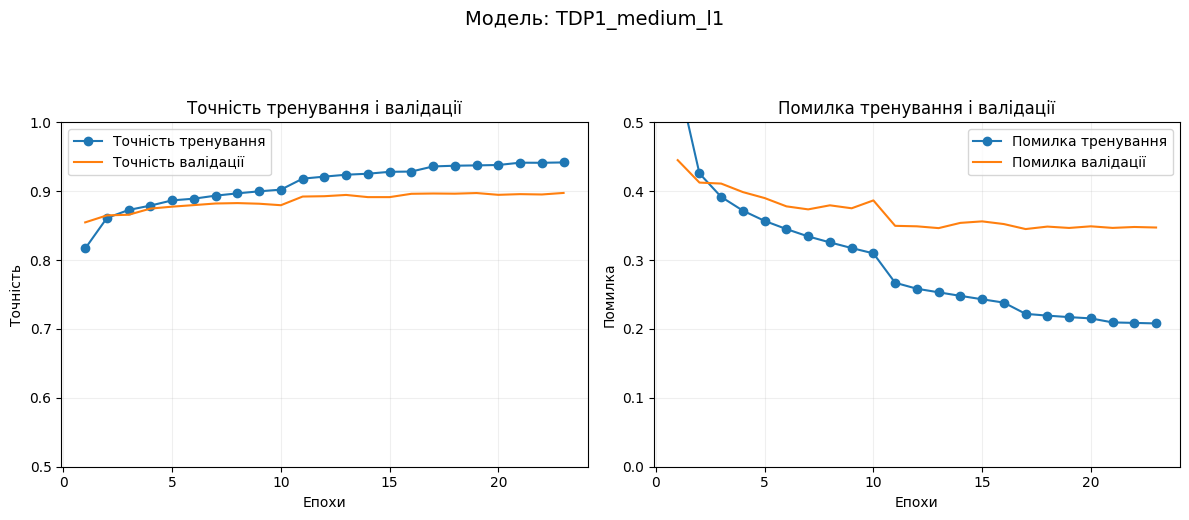

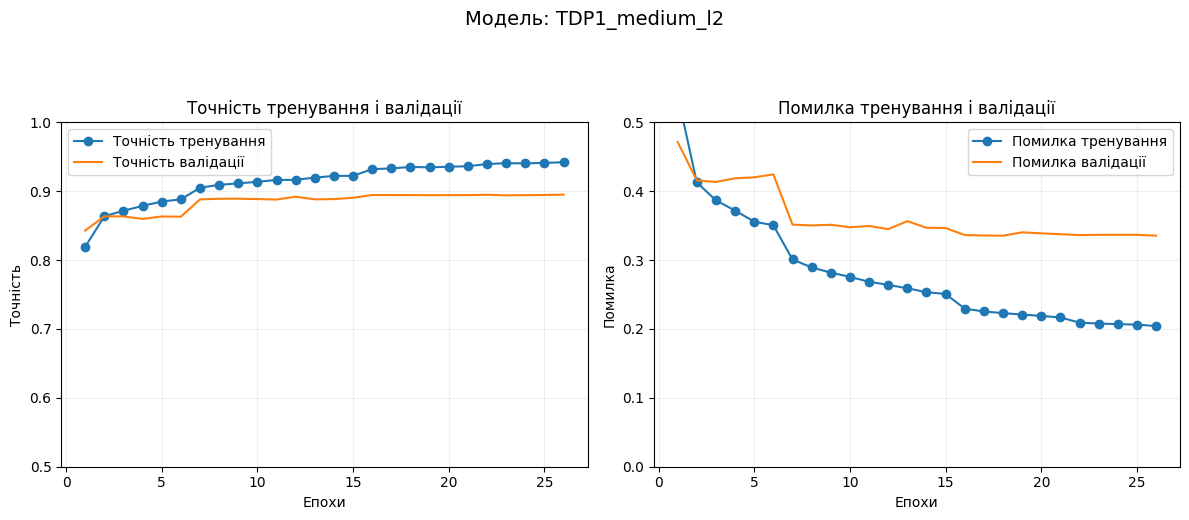

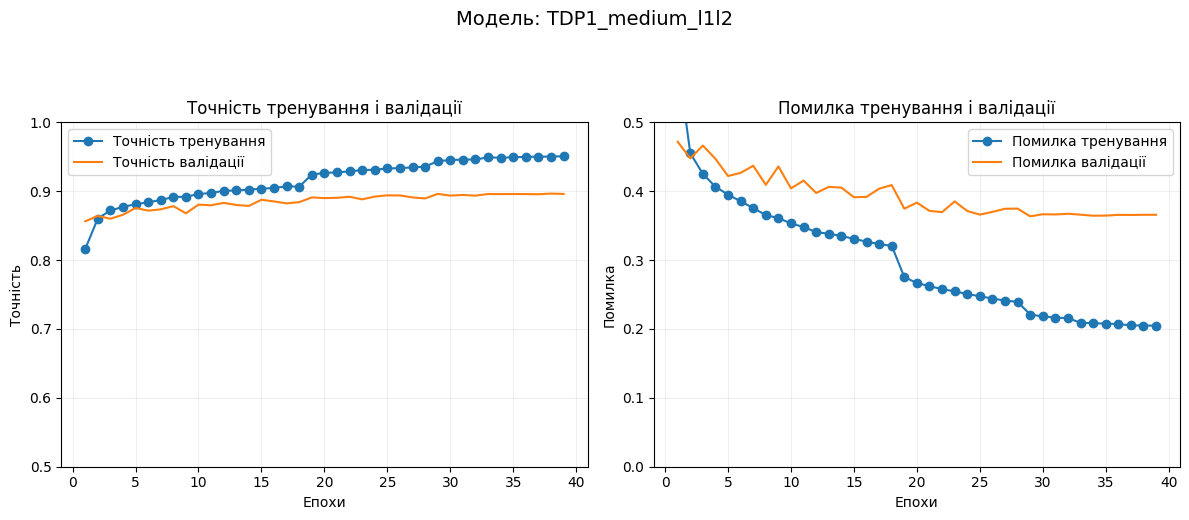

In [32]:
display_results(optimization_histories['l1'])
display_results(optimization_histories['l2'])
display_results(optimization_histories['l1l2'])

Виведемо результати фактичної помилки валідаційних даних всіх моделей для порівняння і визначення ефективності оптимізаційних методів, з урахуванням регуляризаційних штрафів:

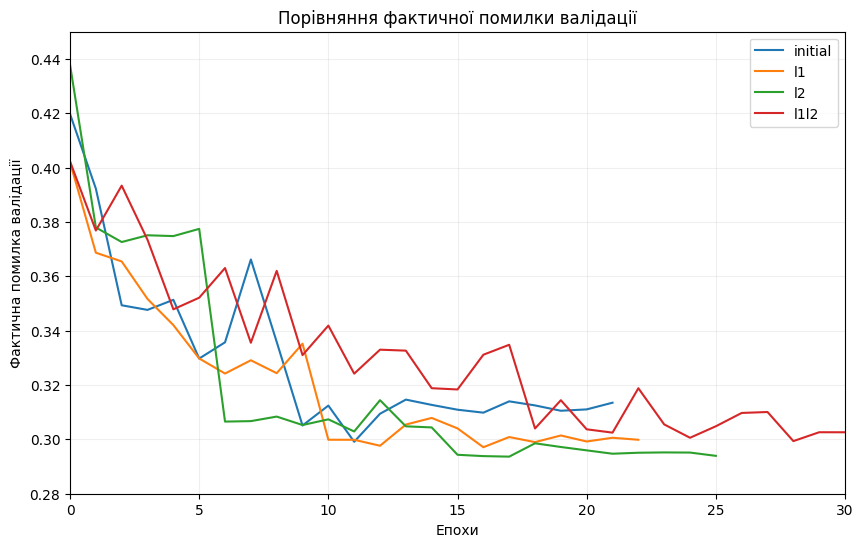

In [33]:
display_all_results(optimization_histories, 'val_xent', miny=0.28, title='Порівняння фактичної помилки валідації', ylabel='Фактична помилка валідації')

Для додаткової наглядності та остаточного рішення, виведемо точність валідаційних даних всіх моделей:

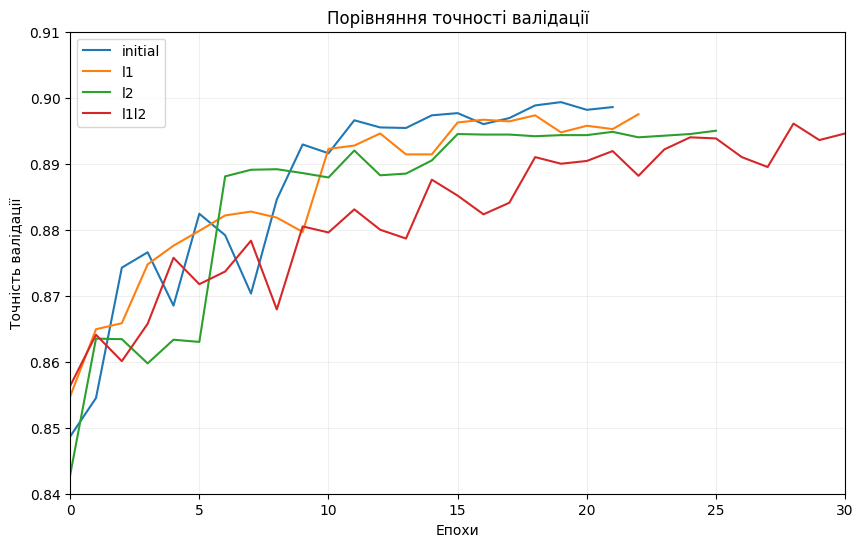

In [34]:
display_all_results(optimization_histories, 'val_accuracy', miny=0.84, maxy=0.91, title='Порівняння точності валідації', ylabel='Точність валідації')

Як результат тестувань, встановимо 0.00001, як значення параметрeа L1 та 0.0001, як значення параметра L2, вони є найбільш ідеальними для конкретно цієї тестової вибірки.

У висновку, можемо побачити, що:


*   Без регуляризації: нестабільна точність та перенавчання даними;
*   Регуляризація L1: ліквідація перенавчання, однак гірші результати за відсутність регуляризації та гірша стабільність;
*   Регуляризація L2: ліквідація перенавчання, задовільні результати та задовільна стабільність;
*   Регуляризація L1 + L2: ліквідація перенавчання, кращі результати за відсутність регуляризації та найкраща стабільність.

Як результат, оберемо регуляризацію L1 + L2 і продовжимо оптимізацію.





Збережемо найкращу модель як основну:

In [35]:
model_medium_l1l2.save('tdp1_model_v3.keras')
print('\nЗбережено модель tdp1_model_v3')


Збережено модель tdp1_model_v3


Додамо Dropout як фінальний метод оптимізації. Створимо три нові моделі, аби знайти найбільш оптимальне значення Dropout - моделі міститимуть слої Dropout зі значеннями 0.2, 0.35 і 0.5, відповідно:

In [36]:
model_medium_l1l2_dropout02 = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.20),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.20),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_medium_l1l2_dropout0.2'
)

model_medium_l1l2_dropout035 = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.35),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.35),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_medium_l1l2_dropout0.35'
)

model_medium_l1l2_dropout05 = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_medium_l1l2_dropout0.5'
)

Виконаємо компіляцію та тестування нових моделей для визначення найкращого значення Dropout:

In [37]:
initial_model = keras.models.load_model('tdp1_model_v3.keras')

dropout_histories = {}
dropout_histories['initial'] = optimization_histories['l1l2']
dropout_histories['d0.2'] = compile_and_fit(model_medium_l1l2_dropout02)
dropout_histories['d0.35'] = compile_and_fit(model_medium_l1l2_dropout035)
dropout_histories['d0.5'] = compile_and_fit(model_medium_l1l2_dropout05)

Model: "TDP1_medium_l1l2_dropout0.2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7148 - loss: 0.8726 - xent: 0.7997
Epoch 1: val_xent did not improve from 0.29364
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7151 - loss: 0.8718 - xent: 0.7989 - val_accuracy: 0.8398 - val_loss: 0.5112 - val_xent: 0.4387 - learning_rate: 0.0010
Epoch 2/10000
1489/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8340 - loss: 0.5294 - xent: 0.4562
Epoch 2: val_xent did not improve from 0.29364
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8340 - loss: 0.5293 - xent: 0.4561 - val_accuracy: 0.8522 - val_loss: 0.4844 - val_xent: 0.4089 - learning_rate: 0.0010
Epoch 3/10000
1488/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8489 - loss: 0.4947 - xent: 0.4181
Epoch 3: val_xent did not improve from 0.29364
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8489 - loss: 0.4947 - xent: 0.4181 - val_accuracy: 0.8611 - val_loss: 0.4616 - val_xent: 0.3831 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_medium_l1l2_dropout0.35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1490/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6648 - loss: 0.9975 - xent: 0.9256
Epoch 1: val_xent did not improve from 0.29078
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6654 - loss: 0.9958 - xent: 0.9239 - val_accuracy: 0.8253 - val_loss: 0.5367 - val_xent: 0.4642 - learning_rate: 0.0010
Epoch 2/10000
1489/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8157 - loss: 0.5882 - xent: 0.5149
Epoch 2: val_xent did not improve from 0.29078
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8157 - loss: 0.5882 - xent: 0.5148 - val_accuracy: 0.8495 - val_loss: 0.4857 - val_xent: 0.4096 - learning_rate: 0.0010
Epoch 3/10000
1491/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8318 - loss: 0.5488 - xent: 0.4717
Epoch 3: val_xent did not improve from 0.29078
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8318 - loss: 0.5488 - xent: 0.4717 - val_accuracy: 0.8585 - val_loss: 0.4672 - val_xent: 0.3877 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_medium_l1l2_dropout0.5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5846 - loss: 1.2023 - xent: 1.1319
Epoch 1: val_xent did not improve from 0.29078
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5847 - loss: 1.2020 - xent: 1.1316 - val_accuracy: 0.8240 - val_loss: 0.5600 - val_xent: 0.4914 - learning_rate: 0.0010
Epoch 2/10000
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7815 - loss: 0.6785 - xent: 0.6090
Epoch 2: val_xent did not improve from 0.29078
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7816 - loss: 0.6785 - xent: 0.6090 - val_accuracy: 0.8416 - val_loss: 0.5187 - val_xent: 0.4461 - learning_rate: 0.0010
Epoch 3/10000
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8019 - loss: 0.6316 - xent: 0.5581
Epoch 3: val_xent did not improve from 0.29078
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8019 - loss: 0.6316 - xent: 0.5581 - val_accuracy: 0.8452 - val_loss: 0.4945 - val_xent: 0.4183 - learning_rate: 0.0010
Epoch 4/1

Виведемо на 3 різні графіки результати тестувань та валідації кожної з нових моделей:

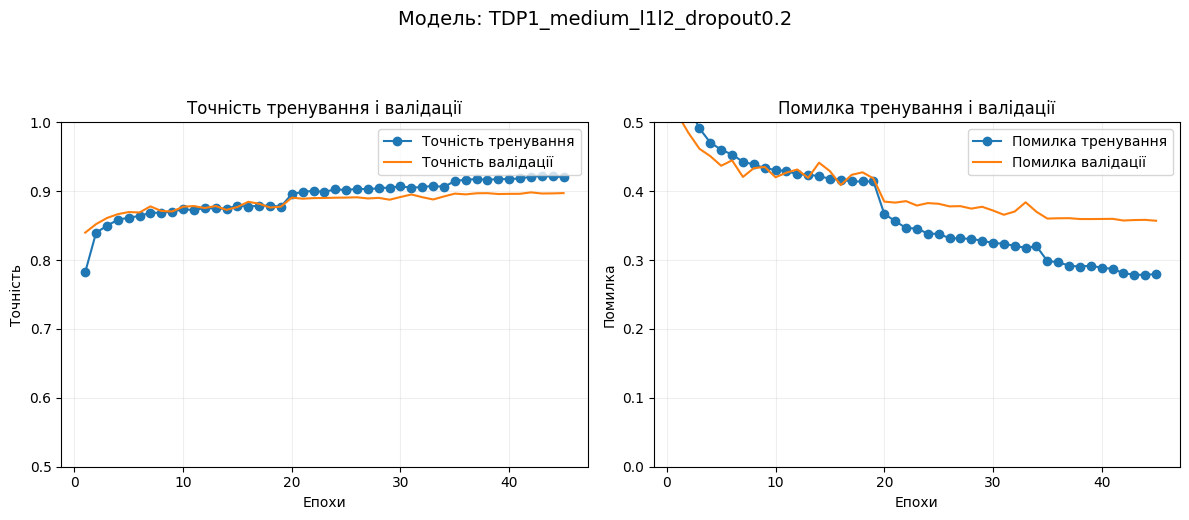

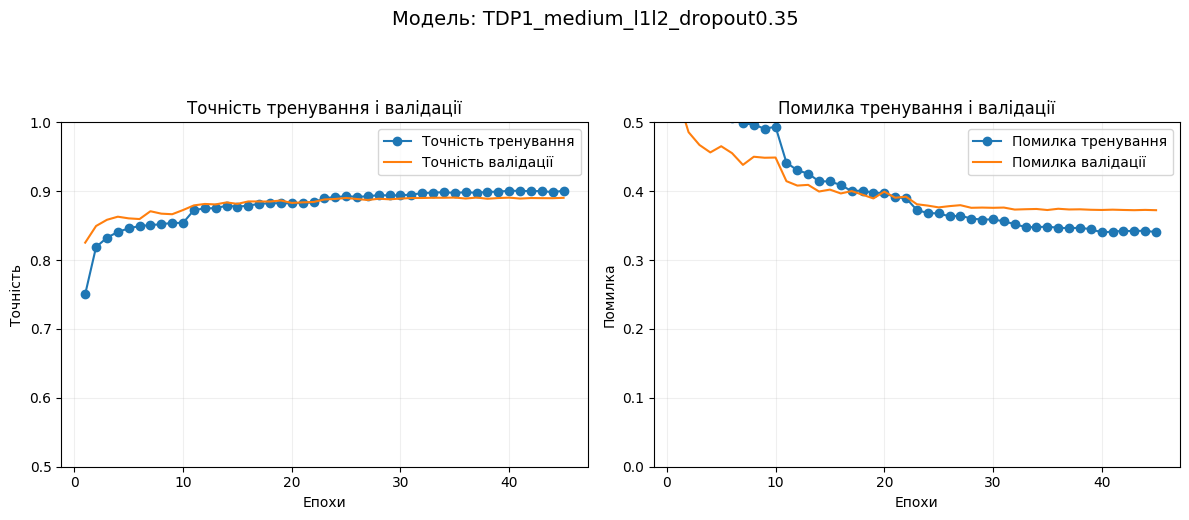

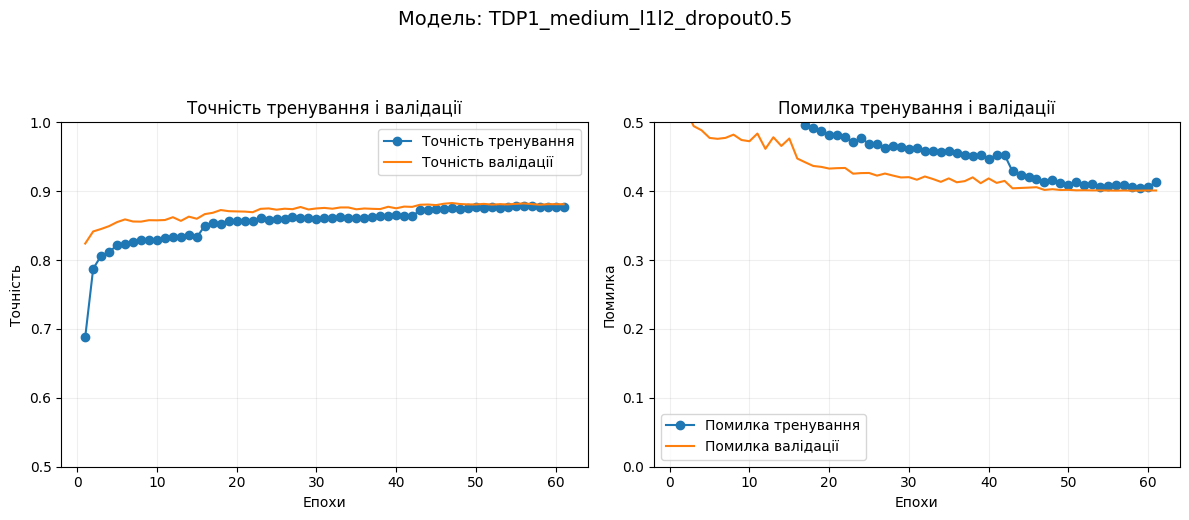

In [38]:
display_results(dropout_histories['d0.2'])
display_results(dropout_histories['d0.35'])
display_results(dropout_histories['d0.5'])

Виведемо результати фактичної помилки всіх моделей для порівняння ефективності різних значень Dropout на одному графіку:

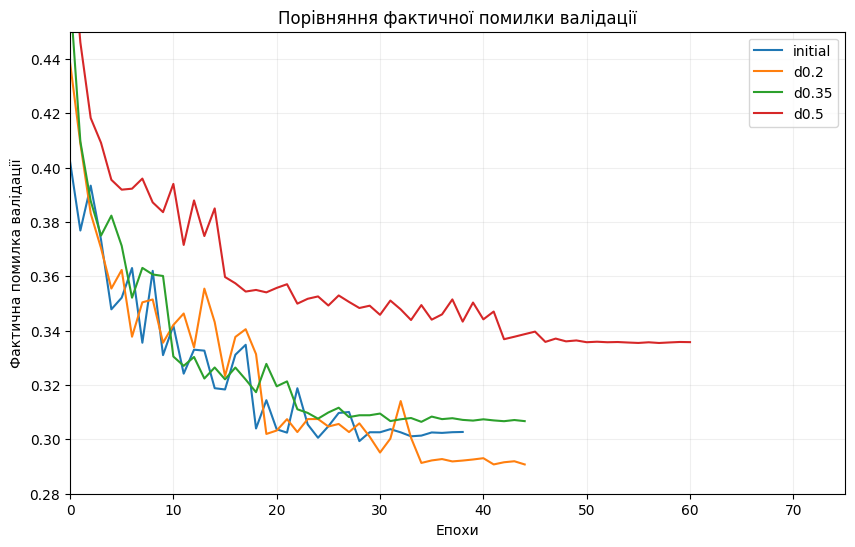

In [39]:
display_all_results(dropout_histories, 'val_xent', miny=0.28,
                    title='Порівняння фактичної помилки валідації', ylabel='Фактична помилка валідації',
                    epochs=75)

Можемо побачити, що найкращим серед обраних значень значенням Dropout є 0.2, тож застосуємо його і збережемо цю версію моделі:

In [40]:
model_medium_l1l2_dropout02.save('tdp1_model_v4.keras')
print('\nЗбережено модель tdp1_model_v4')


Збережено модель tdp1_model_v4


Нарешті, налаштуємо розмір батчу шляхом порівняння різних значень параметра:

In [41]:
initial_model = keras.models.load_model('tdp1_model_v4.keras')
model_b16 = initial_model
model_b32 = initial_model
model_b64 = initial_model
model_b128 = initial_model

batchsize_histories = {}
batchsize_histories['initial'] = dropout_histories['d0.2']
batchsize_histories['b16'] = compile_and_fit(model_b16, batch_size=16)
batchsize_histories['b32'] = compile_and_fit(model_b32, batch_size=32)
batchsize_histories['b64'] = compile_and_fit(model_b64, batch_size=64)
batchsize_histories['b128'] = compile_and_fit(model_b128, batch_size=128)

Model: "TDP1_medium_l1l2_dropout0.2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
2994/3000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8716 - loss: 0.4188 - xent: 0.3481
Epoch 1: val_xent did not improve from 0.29078
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8715 - loss: 0.4188 - xent: 0.3482 - val_accuracy: 0.8741 - val_loss: 0.4207 - val_xent: 0.3394 - learning_rate: 0.0010
Epoch 2/10000
2996/3000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8719 - loss: 0.4338 - xent: 0.3508
Epoch 2: val_xent did not improve from 0.29078
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8719 - loss: 0.4338 - xent: 0.3508 - val_accuracy: 0.8593 - val_loss: 0.4708 - val_xent: 0.3834 - learning_rate: 0.0010
Epoch 3/10000
2995/3000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8686 - loss: 0.4431 - xent: 0.3547
Epoch 3: val_xent did not improve from 0.29078
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8686 - loss: 0.4431 - xent: 0.3547 - val_accuracy: 0.8702 - val_loss: 0.4441 - val_xent: 0.3525 - learning_rate: 0.0010
Epoch 4

Model: "TDP1_medium_l1l2_dropout0.2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1496/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8890 - loss: 0.3726 - xent: 0.3009
Epoch 1: val_xent did not improve from 0.29078
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8890 - loss: 0.3726 - xent: 0.3009 - val_accuracy: 0.8793 - val_loss: 0.4045 - val_xent: 0.3274 - learning_rate: 0.0010
Epoch 2/10000
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8857 - loss: 0.3847 - xent: 0.3066
Epoch 2: val_xent did not improve from 0.29078
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8857 - loss: 0.3847 - xent: 0.3066 - val_accuracy: 0.8817 - val_loss: 0.4115 - val_xent: 0.3301 - learning_rate: 0.0010
Epoch 3/10000
1494/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8852 - loss: 0.3876 - xent: 0.3057
Epoch 3: val_xent did not improve from 0.29078
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8852 - loss: 0.3877 - xent: 0.3058 - val_accuracy: 0.8728 - val_loss: 0.4394 - val_xent: 0.3559 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_medium_l1l2_dropout0.2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8982 - loss: 0.3423 - xent: 0.2724
Epoch 1: val_xent did not improve from 0.29078
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8982 - loss: 0.3424 - xent: 0.2724 - val_accuracy: 0.8845 - val_loss: 0.3950 - val_xent: 0.3219 - learning_rate: 0.0010
Epoch 2/10000
741/750 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9019 - loss: 0.3346 - xent: 0.2612
Epoch 2: val_xent did not improve from 0.29078
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9019 - loss: 0.3347 - xent: 0.2613 - val_accuracy: 0.8886 - val_loss: 0.3816 - val_xent: 0.3064 - learning_rate: 0.0010
Epoch 3/10000
745/750 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8975 - loss: 0.3518 - xent: 0.2763
Epoch 3: val_xent did not improve from 0.29078
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8975 - loss: 0.3518 - xent: 0.2763 - val_accuracy: 0.8871 - val_loss: 0.3924 - val_xent: 0.3158 - learning_rate: 0.0010
Epoch 4/10000
746/750 

Model: "TDP1_medium_l1l2_dropout0.2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
370/375 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9110 - loss: 0.3100 - xent: 0.2387
Epoch 1: val_xent did not improve from 0.29078
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9110 - loss: 0.3101 - xent: 0.2388 - val_accuracy: 0.8896 - val_loss: 0.3843 - val_xent: 0.3119 - learning_rate: 0.0010
Epoch 2/10000
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9108 - loss: 0.3139 - xent: 0.2413
Epoch 2: val_xent did not improve from 0.29078
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9108 - loss: 0.3140 - xent: 0.2414 - val_accuracy: 0.8870 - val_loss: 0.3949 - val_xent: 0.3214 - learning_rate: 0.0010
Epoch 3/10000
367/375 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9101 - loss: 0.3162 - xent: 0.2427
Epoch 3: val_xent did not improve from 0.29078
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9101 - loss: 0.3163 - xent: 0.2428 - val_accuracy: 0.8898 - val_loss: 0.3910 - val_xent: 0.3172 - learning_rate: 0.0010
Epoch 4/10000
371/375 

Виведемо результати валідаційних фактичної помилки та точності на два графіки:

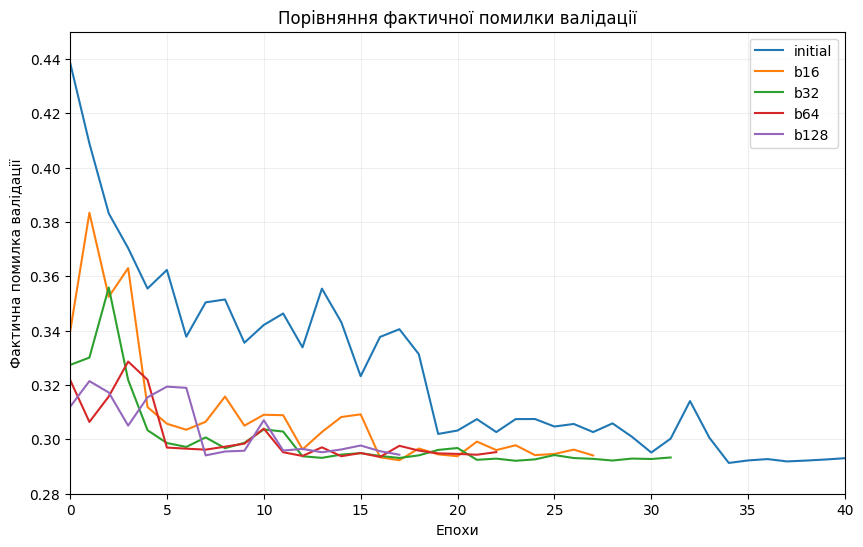

In [42]:
display_all_results(batchsize_histories, 'val_xent', miny=0.28,
                    title='Порівняння фактичної помилки валідації', ylabel='Фактична помилка валідації',
                    epochs=40)

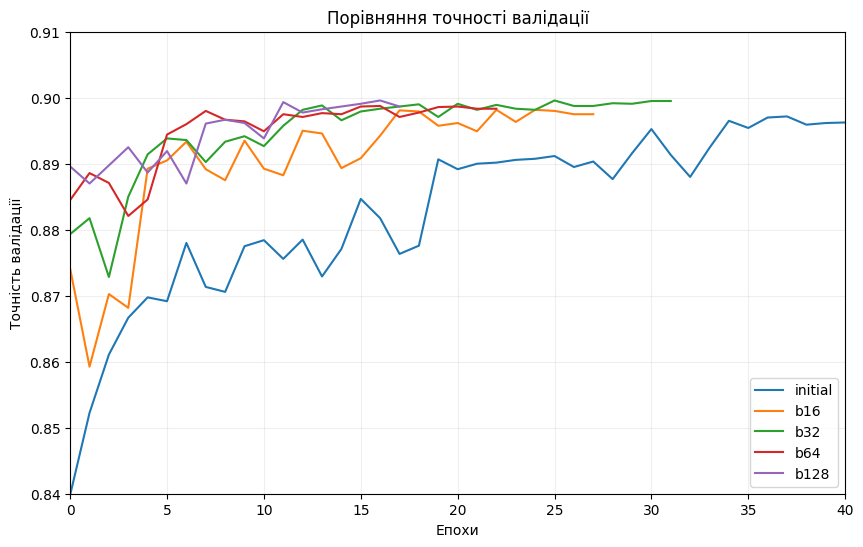

In [43]:
display_all_results(batchsize_histories, 'val_accuracy', miny=0.84, maxy=0.91,
                    title='Порівняння точності валідації', ylabel='Точність валідації',
                    epochs=40)

Як можемо побачити, розміри батчу в 16 і 32 мають значно кращі результати за розмір за замовчуванням, однак розмір батчу в 32 має кращу швидкість за нижчі розміри, тож оберемо саме його.

Так як архітектура моделі залишилася незмінною, збережемо лише нові гіперпараметри, окремо:

In [44]:
model_b32.save_weights('tdp1_model_v4.weights.h5')
print('\nЗбережено вагові коефіцієнти моделі tdp1_model_v4')


Збережено вагові коефіцієнти моделі tdp1_model_v4


Нарешті, протестуємо налаштовану та оптимізовану модель на реальних тестових даних:

In [45]:
final_model = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.20),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.20),
    keras.layers.Dense(10, activation='softmax')
    ]
)

final_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        'accuracy',
        keras.losses.SparseCategoricalCrossentropy(name='xent')
            ]
    )

final_model.load_weights('tdp1_model_v4.weights.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [46]:
print("\n--- Перевіряємо точність фінальної моделі на тестових даних ---")

final_test_loss, final_test_accuracy, final_test_xent = final_model.evaluate(test_images, test_labels, verbose=2)

print("\nФінальна тестова точність:", final_test_accuracy)
print("Фінальна тестова помилка:", final_test_loss)


--- Перевіряємо точність фінальної моделі на тестових даних ---
313/313 - 1s - 5ms/step - accuracy: 0.8906 - loss: 0.3956 - xent: 0.3210

Фінальна тестова точність: 0.8906000256538391
Фінальна тестова помилка: 0.39564770460128784


In [47]:
best_checkpoint_model = keras.models.load_model('best_model_checkpoint.keras')

print("\n--- Перевіряємо точність збереженої контрольною точкою найкращої моделі на тестових даних ---")

checkpoint_test_loss, checkpoint_test_accuracy, checkpoint_test_xent = best_checkpoint_model.evaluate(test_images, test_labels, verbose=2)

print("\nТочність найкращої моделі з контрольної точки:", checkpoint_test_accuracy)
print("Помилка найкращої моделі з контрольної точки:", checkpoint_test_loss)


--- Перевіряємо точність збереженої контрольною точкою найкращої моделі на тестових даних ---
313/313 - 1s - 3ms/step - accuracy: 0.8895 - loss: 0.3814 - xent: 0.3148

Точність найкращої моделі з контрольної точки: 0.8895000219345093
Помилка найкращої моделі з контрольної точки: 0.38142451643943787


In [48]:
if final_test_xent <= checkpoint_test_xent:
    best_model_accuracy = final_test_accuracy
    best_model_xent = final_test_xent
    best_model_name = "фінальну модель"
else:
    best_model_accuracy = checkpoint_test_accuracy
    best_model_xent = checkpoint_test_xent
    best_model_name = "найкращу модель контрольної точки"

print(f"\nВибрано {best_model_name} для порівняння з початковою моделлю.")

accuracy_improvement = ((best_model_accuracy - test_accuracy) / test_accuracy) * 100
xent_reduction = ((test_xent - best_model_xent) / test_xent) * 100

print("Покращення тестової точності: {:.2f}%".format(accuracy_improvement))
print("Покращення фактичної тестової помилки: {:.2f}%".format(xent_reduction))


Вибрано найкращу модель контрольної точки для порівняння з початковою моделлю.
Покращення тестової точності: 2.44%
Покращення фактичної тестової помилки: 17.40%


Можемо побачити покращення результатів як точності, так і помилки моделі. Як наслідок, створено та оптимізовану просту модель для задачі класифікації рівномірно розподілених по класах зображень.